### This guidebook demonstrates how to identify the top employee names in JUUL using email network analysis. We will use centrality measures to determine the most influential individuals in the network.

#### Import the required libraries

In [1]:
import requests
import pandas as pd
import re
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go


### Step 1: Gather the email metadata using the API
##### Note: The query may take a few minutes to run depending on the query input.
For example, the query input can be query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND type:"email" AND "launch party")'. This retrieves all emails related to the launch party.

Another query input could be query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND type:"email")'. This retrieves all emails present in the respository related to the JUUL vs State of North Carolina lawsuit.


In [ ]:
# Define the query_solr_api function
def query_solr_api(query, format='json', sort_field='id', cursor_mark='*'):
    global documents_list  # Declare documents_list as global
    base_api = f'https://solr.idl.ucsf.edu/solr/ltdl3/query?q={query}&wt={format}'
    documents_list = []  # Initialize the global documents_list

    # while loop to retrieve documents, the loop will run as long as the cursor mark is valid
    while cursor_mark:
        api_final = f"{base_api}&cursorMark={cursor_mark}&sort={sort_field}%20desc"  # constructs the final API url with the current cursor_mark and sorting
        try:
            response = requests.get(api_final)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print(f"Error: {e}")
            break

        data = response.json()
        documents = data.get('response', {}).get('docs', [])  # extracts the list of documents from the response.
        documents_list.extend(documents)  # adds all document metadata to documents_list

        # prints information about the current step
        print(f"Retrieved {len(documents)} documents. Total documents collected: {len(documents_list)}")

        # retrieves the next cursor mark for next set of documents. Checks if the cursor_mark hasn't changed to avoid an infinite loop, breaking the loop if it hasn't.
        next_cursor_mark = data.get('nextCursorMark', None)
        if cursor_mark == next_cursor_mark:
            break
        cursor_mark = next_cursor_mark

    # Final output information
    print(f"Total number of documents collected: {len(documents_list)}")
    print(f"Last cursor mark used: {cursor_mark}")

    return documents_list

# Function to save the documents list to a CSV file, focusing on specific email metadata
def save_to_csv(documents_list, filename='JUUL_email_metadata.csv'):
    # Extract only relevant fields
    relevant_fields = ['id','author', 'copied', 'recipient']
    filtered_docs = [{field: doc.get(field, None) for field in relevant_fields} for doc in documents_list]

    # Create a DataFrame from the filtered documents list
    df = pd.DataFrame(filtered_docs)

    # Save DataFrame to CSV
    df.to_csv(filename, index=False)

# Example usage of the function
def main():
    query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND type:"email")' # modify query as required
    documents_list = query_solr_api(query)
    save_to_csv(documents_list, 'juul_email_metadata.csv')

# Ensures that main function is called only if the script is run directly (not imported as a module)
if __name__ == "__main__":
    main()


Example of what the output from the API wrapper should look like 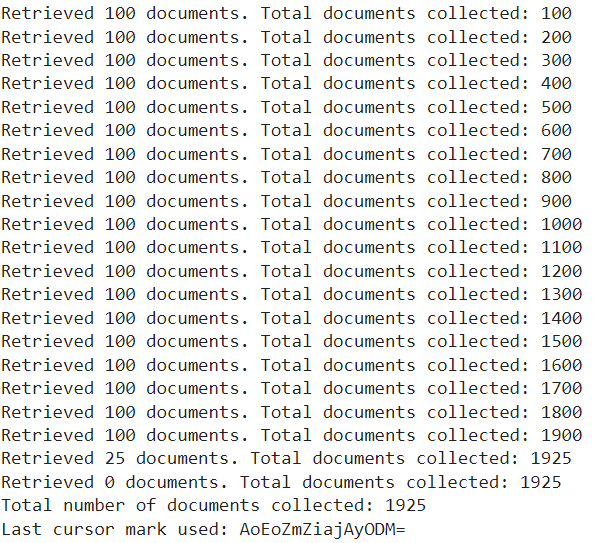

Sanity check: Check for duplicate document ids



In [ ]:
#Checks for duplicates of ids in csv and removes duplicate ids

df_check = pd.read_csv('juul_email_metadata.csv') #modify the csv file name as required
number_of_duplicates = df_check.duplicated().sum()
# Remove duplicates if present
if number_of_duplicates > 0:
  df_check.drop_duplicates(inplace=True)
  print("Duplicates removed.")
else:
  print("No duplicates found.")

#df_check.to_csv('juul_email_metadata_cleaned.csv', index=False) #save the updated csv if required


Example of data in juul_email_metadata.csv

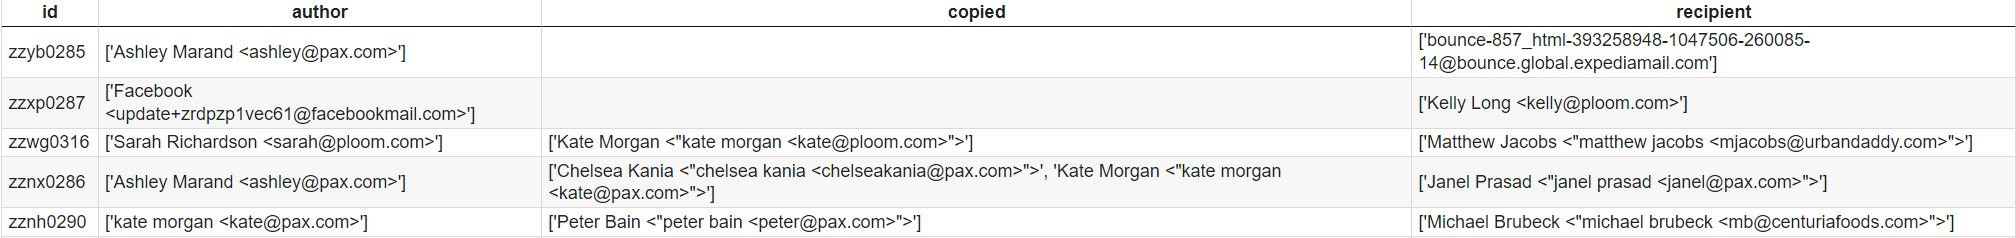

### Step 1: Data Preparation
Extracting the author name and email followed by addition of the relevant tag for JUUL employees. Emails with domain names juul.com, pax.com, ploom.com, juullabs.com are used to identify JUUL employees.

Note: Although Juul Labs, Inc. and Pax Labs are separate companies, JUUL part of PAX Labs (formerly known as Ploom) prior to 2017. Hence, email domains of all companies are used to identify employees

In [6]:
# Function to clean and extract author names and email addresses
def extract_emails(email_list, tag):
    extracted = []
    for email in email_list:
        # Remove brackets and split by commas if necessary
        email = email.strip("[]").replace("'", "")
        email_entries = email.split(", ")
        for entry in email_entries:
            # Regex to extract email addresses and names
            matches = re.findall(r'([^<>"]+)\s*<([^<>]+)>', entry)
            for match in matches:
                name, email_addr = match
                name = name.strip().strip('"')  # Clean up extra quotes and spaces
                email_addr = email_addr.strip()
                if any(domain in email_addr for domain in ['juul.com', 'pax.com', 'ploom.com', 'juullabs.com']):
                    extracted.append({'name': name, 'email': email_addr, 'tag': tag})
    return extracted

# Read email data from CSV file
email_data_df = pd.read_csv('juul_email_metadata.csv')

# Extract email data from each relevant column with corresponding tags
author_emails = extract_emails(email_data_df['author'].dropna().tolist(), 'author')
copied_emails = extract_emails(email_data_df['copied'].dropna().tolist(), 'copied')
recipient_emails = extract_emails(email_data_df['recipient'].dropna().tolist(), 'recipient')

# Combine all extracted emails
combined_emails = author_emails + copied_emails + recipient_emails

# Create a DataFrame from the combined emails
df = pd.DataFrame(combined_emails)

# Save to CSV
df.to_csv('JUUL employee emails.csv', index=False)


Example of JUUL Employee Email.csv output
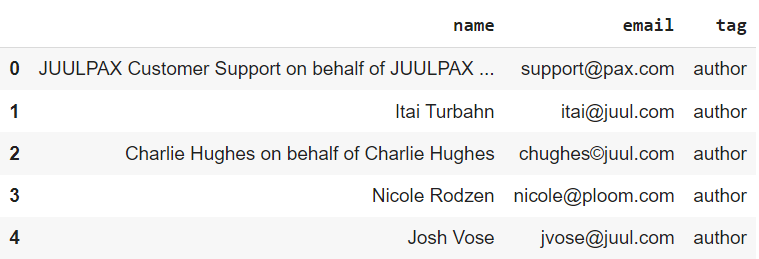

### Step 2: Count frequency of email addresses
Use value_counts() to count the occurrences of each email address and top 50 email addresses for each category.

In [7]:
# Create separate DataFrames based on the 'tag' column
author_df = df[df['tag'] == 'author']
recipient_df = df[df['tag'] == 'recipient']
copied_df = df[df['tag'] == 'copied']

# Count unique email addresses and their frequencies
author_frequencies = author_df['email'].value_counts()
recipient_frequencies = recipient_df['email'].value_counts()
copied_frequencies = copied_df['email'].value_counts()

# Count unique email addresses and their frequencies (Top 50)
author_frequencies_top50 = author_df['email'].value_counts().head(50) # modify the number to view the top X as required
recipient_frequencies_top50 = recipient_df['email'].value_counts().head(50) # modify the number to view the top X as required
copied_frequencies_top50 = copied_df['email'].value_counts().head(50) # modify the number to view the top X as required

In [ ]:
# View the counts (Optional)
print(author_frequencies,recipient_frequencies, copied_frequencies)
print(author_frequencies_top50, recipient_frequencies_top50, copied_frequencies_top50, )

In [ ]:
# Save the email frequencies to CSV files (Optional)
author_frequencies.to_csv('author_frequencies.csv', header=['count'])
recipient_frequencies.to_csv('recipient_frequencies.csv', header=['count'])
copied_frequencies.to_csv('copied_frequencies.csv', header=['count'])

Plot bar charts to visualize the top 50 email frequencies for each category using matplotlib.

In [ ]:
# Visualization of the top 50 for author, copied, and recipient
plt.figure(figsize=(21, 9))

plt.subplot(1, 3, 1)
author_frequencies_top50.plot(kind='bar')
plt.title('Top 50 Author Email Frequencies')
plt.xlabel('Email')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
recipient_frequencies_top50.plot(kind='bar')
plt.title('Top 50 Recipient Email Frequencies')
plt.xlabel('Email')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
copied_frequencies_top50.plot(kind='bar')
plt.title('Top 50 Copied Email Frequencies')
plt.xlabel('Email')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Example of bar chart based on code above
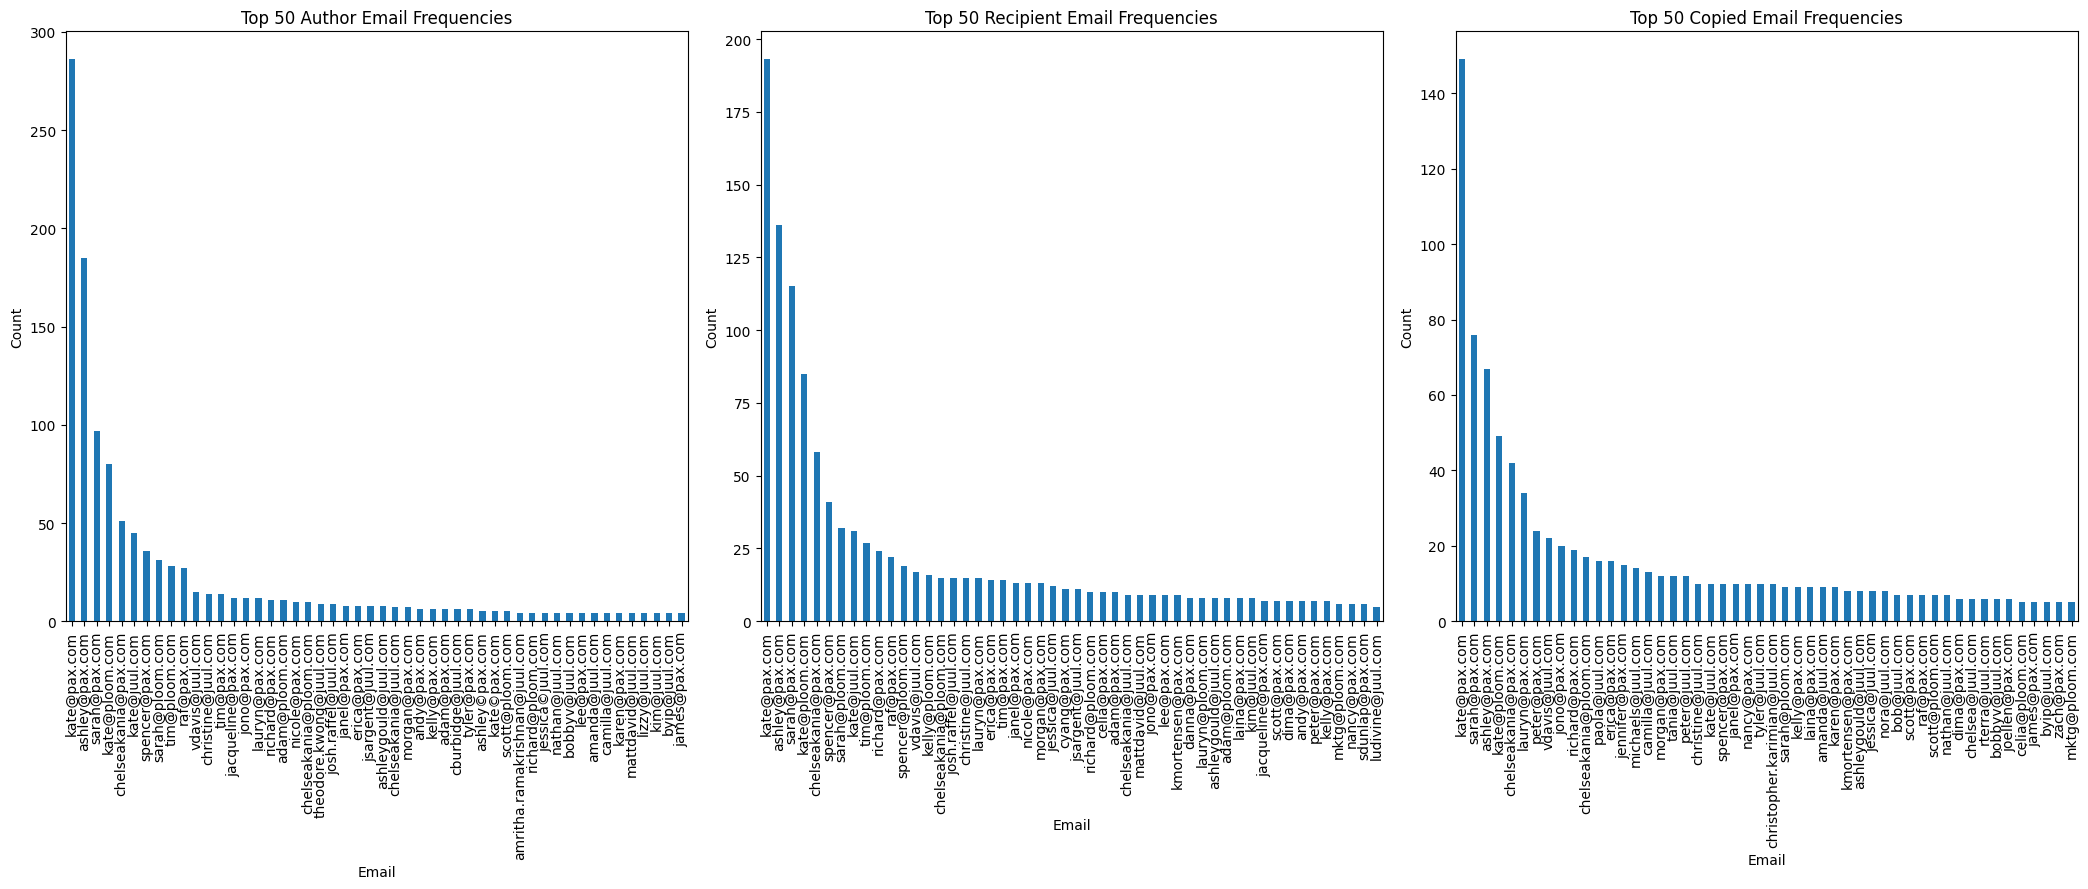

### Step 3: Create an interactive plot of an email interaction network using NetworkX and Plotly.

In an email network, the same pair of nodes (email addresses) can have multiple interaction, we can capture the volume and frequency of email interactions between the same sender and recipient using MultiDiGraph (directed multigraph).

The codes also calculates the degree centrality for each node in the graph, which measures the number of connections (both in and out). Nodes with high degree centrality are key players in the network. They are either highly communicative (sending many emails) or highly sought after (receiving many emails).

Sorts nodes by degree centrality in descending order and selects the top 50 nodes for ease of visualization.
Nodes with 0 connections are removed and the positions of the nodes are computed using the spring layout algorithm, which positions nodes to minimize edge crossings and distribute them evenly.



In [ ]:
# Create lists of email interactions for authors and recipients
edges = []
for _, row in df.iterrows():
    if row['tag'] == 'author':
        author_email = row['email']
    elif row['tag'] == 'recipient':
        recipient_email = row['email']
        edges.append((author_email, recipient_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate degree centrality (combining in-degree and out-degree)
degree_centrality = nx.degree_centrality(G)

# Identify top 50 nodes based on degree centrality
top_50_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_degree = [node for node, _ in top_50_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph
pos = nx.spring_layout(H)

# Hover text to mention # of Connections
degrees = dict(H.degree())
hover_texts = [f'Node: {node}<br># of Connections: {degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [degrees[node] for node in H.nodes()]

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=hover_texts,
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node Connections', xanchor='left',
                                                  titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False,
                                                                           showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False,
                                                                           showticklabels=False)))

fig.show()

In [ ]:
# Save overall centrality scores to CSV
overall_centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Email', 'Degree Centrality'])
overall_centrality_df.to_csv('overall_degree_centrality_scores.csv', index=False)

# Save top 50 centrality scores to CSV
top_50_centrality_df = pd.DataFrame(top_50_degree, columns=['Email', 'Degree Centrality'])
top_50_centrality_df.to_csv('top_50_degree_centrality_scores.csv', index=False)

####Visualize the graph for the top 50 senders (authors) based on out-degree centrality.

Out-degree centrality measures the number of outgoing edges from a node (individual), indicating its influence in terms of sending emails.

Note: Out-degree centrality might be 0 for nodes that do not have any outgoing edges. This means that the node (email address) did not send any emails to other nodes (individuals) within the dataset or the specified subgraph. Such nodes could either be recipients only, or they could be isolated in terms of sending emails within the context of the analyzed email interactions.

In [ ]:
# Create lists of email interactions for authors and recipients
edges = []
for _, row in df.iterrows():
    if row['tag'] == 'author':
        author_email = row['email']
    elif row['tag'] == 'recipient':
        recipient_email = row['email']
        edges.append((author_email, recipient_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate out-degree centrality
out_degree_centrality = nx.out_degree_centrality(G)

# Identify top 50 nodes based on out-degree centrality
top_50_out_degree = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_out_degree = [node for node, _ in top_50_out_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_out_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph
pos = nx.spring_layout(H, seed = 42)

# Hover text to mention # of Connections
out_degrees = dict(H.out_degree())
hover_texts = [f'Node: {node}<br># of Connections: {out_degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [out_degrees[node] for node in H.nodes()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=[f'Node: {node}<br># of Outgoing Connections: {out_degrees[node]}' for node in H.nodes()],
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node Out-Degree', xanchor='left', titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [ ]:
# Save overall out-degree centrality scores to CSV
overall_centrality_df = pd.DataFrame(list(out_degree_centrality.items()), columns=['Email', 'Out-Degree Centrality'])
overall_centrality_df.to_csv('overall_out_degree_centrality_scores.csv', index=False)

# Save top 50 out-degree centrality scores to CSV
top_50_centrality_df = pd.DataFrame(top_50_out_degree, columns=['Email', 'Out-Degree Centrality'])
top_50_centrality_df.to_csv('top_50_out_degree_centrality_scores.csv', index=False)

####Visualize the graph for the top 50 recipients based on in-degree centrality.
In-degree centrality measures the number of incoming edges from a node (individual), indicating its influence in terms of receiving emails.

In [ ]:
# Create lists of email interactions for authors and recipients
edges = []
for _, row in df.iterrows():
    if row['tag'] == 'author':
        author_email = row['email']
    elif row['tag'] == 'recipient':
        recipient_email = row['email']
        edges.append((author_email, recipient_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate in-degree centrality
in_degree_centrality = nx.in_degree_centrality(G)

# Identify top 50 nodes based on in-degree centrality
top_50_in_degree = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_in_degree = [node for node, _ in top_50_in_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_in_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph
pos = nx.spring_layout(H, seed = 42)

# Hover text to mention # of Connections
in_degrees = dict(H.in_degree())
hover_texts = [f'Node: {node}<br># of Connections: {in_degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [in_degrees[node] for node in H.nodes()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=[f'Node: {node}<br># of Incoming Connections: {in_degrees[node]}' for node in H.nodes()],
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node In-Degree', xanchor='left', titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


In [ ]:
# Save overall in-degree centrality scores to CSV
overall_centrality_df = pd.DataFrame(list(in_degree_centrality.items()), columns=['Email', 'In-Degree Centrality Recipient'])
overall_centrality_df.to_csv('overall_in_degree_R_centrality_scores.csv', index=False)

# Save top 50 in-degree centrality scores to CSV
top_50_centrality_df = pd.DataFrame(top_50_in_degree, columns=['Email', 'In-Degree Centrality Recipient'])
top_50_centrality_df.to_csv('top_50_out_degree_R_centrality_scores.csv', index=False)

####Visualize the graph for the top 50 cc'ed individuals based on in-degree centrality.
In-degree centrality measures the number of incoming edges from a node (individual), indicating its influence in terms of receiving emails.

In [ ]:
# Create lists of email interactions for copied (cc'd)
edges = []
for _, row in df.iterrows():
    if row['tag'] == 'author':
        author_email = row['email']
    elif row['tag'] == 'copied':
        copied_email = row['email']
        edges.append((author_email, copied_email))

# Build the directed graph
G = nx.MultiDiGraph()
G.add_edges_from(edges)

# Calculate in-degree centrality (since copied nodes are like recipients)
copied_degree_centrality = nx.in_degree_centrality(G)

# Identify top 50 nodes based on copied degree centrality
top_50_copied_degree = sorted(copied_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:50] # modify the top X number as required.
top_50_nodes_by_copied_degree = [node for node, _ in top_50_copied_degree]

# Create a subgraph with the top 50 nodes
H_sub = G.subgraph(top_50_nodes_by_copied_degree)

# Create a new MultiDiGraph based on the subgraph
H = nx.MultiDiGraph()
H.add_nodes_from(H_sub.nodes(data=True))
H.add_edges_from(H_sub.edges(keys=True, data=True))

# Remove nodes with 0 connections from the new graph
nodes_with_no_edges = [n for n, d in H.degree() if d == 0]
H.remove_nodes_from(nodes_with_no_edges)

# Layout for the graph without a seed or with different seeds
pos = nx.spring_layout(H, seed=42)

# Hover text to mention # of Connections
copied_degrees = dict(H.in_degree())
hover_texts = [f'Node: {node}<br># of Connections: {copied_degrees[node]}' for node in H.nodes()]

# Extract edge positions and prepare hover text for edges
edge_x = []
edge_y = []
edge_hover_text = []
for edge in H.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    # Display the connected nodes in the hover text
    edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                        text=edge_hover_text)

node_x = [pos[node][0] for node in H.nodes()]
node_y = [pos[node][1] for node in H.nodes()]

node_color = [copied_degrees[node] for node in H.nodes()]
node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=[f'Node: {node}<br># of Incoming Connections: {copied_degrees[node]}' for node in H.nodes()],
                        marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                    colorbar=dict(thickness=15, title='Node Copied-Degree', xanchor='left', titleside='right'), line_width=2))

fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                margin=dict(b=0, l=0, r=0, t=0),
                                                                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()

In [ ]:
# Save overall in-degree centrality scores to CSV
overall_centrality_df = pd.DataFrame(list(copied_degree_centrality.items()), columns=['Email', 'In-Degree Centrality Copied'])
overall_centrality_df.to_csv('overall_in_degree_C_centrality_scores.csv', index=False)

# Save top 50 in-degree centrality scores to CSV
top_50_centrality_df = pd.DataFrame(top_50_copied_degree, columns=['Email', 'In-Degree Centrality Copied'])
top_50_centrality_df.to_csv('top_50_out_degree_C_centrality_scores.csv', index=False)

####Run the code cell below to see the network of all individuals an email address has interacted with (both sent and received).

In [15]:
def create_email_graph(df, email):
    # Create lists of email interactions for authors and recipients
    edges = []
    for _, row in df.iterrows():
        if row['tag'] == 'author':
            author_email = row['email']
        elif row['tag'] == 'recipient':
            recipient_email = row['email']
            edges.append((author_email, recipient_email))

    # Build the directed graph
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)

    # Check if the specified email is in the graph
    if email not in G:
        print(f"Email {email} not found in the dataset.")
        return

    # Create a subgraph centered around the specified email including its neighbors (interacted with)
    neighbors = list(G.successors(email)) + list(G.predecessors(email))
    sub_nodes = [email] + neighbors
    H_sub = G.subgraph(sub_nodes)

    # Calculate degree centrality for the specified node and its neighbors
    degree_centrality = nx.degree_centrality(H_sub)
    out_degrees = dict(H_sub.out_degree())
    in_degrees = dict(H_sub.in_degree())

    # Combine the centrality scores into a single DataFrame
    centrality_data = {
        'Email': list(H_sub.nodes()),
        'Degree Centrality': [degree_centrality[node] for node in H_sub.nodes()],
        'Out-Degree': [out_degrees[node] for node in H_sub.nodes()],
        'In-Degree': [in_degrees[node] for node in H_sub.nodes()]}
    centrality_df = pd.DataFrame(centrality_data)
    file_name = f'centrality_scores_{email.replace("@", "_at_").replace(".", "_")}.csv'
    # centrality_df.to_csv(file_name, index=False) # save score if required

    # Set a seed for reproducibility
    pos = nx.spring_layout(H_sub, seed=42)

    # Hover text to mention # of Connections
    hover_texts = [f'Node: {node}<br># of Outgoing Connections: {out_degrees[node]}<br># of Incoming Connections: {in_degrees[node]}' for node in H_sub.nodes()]

    # Extract edge positions and prepare hover text for edges
    edge_x = []
    edge_y = []
    edge_hover_text = []
    for edge in H_sub.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_hover_text.extend([f'{edge[0]} - {edge[1]}', f'{edge[0]} - {edge[1]}', None])

    edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='text', mode='lines',
                            text=edge_hover_text)

    node_x = [pos[node][0] for node in H_sub.nodes()]
    node_y = [pos[node][1] for node in H_sub.nodes()]

    node_color = [degree_centrality[node] for node in H_sub.nodes()]
    node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', text=hover_texts,
                            marker=dict(showscale=True, colorscale='YlGnBu', color=node_color, size=10,
                                        colorbar=dict(thickness=15, title='Node Degree Centrality', xanchor='left', titleside='right'), line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False, hovermode='closest',
                                                                    margin=dict(b=0, l=0, r=0, t=0),
                                                                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                                                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    fig.show()

# Example usage:
user_email = input("Enter the email address: ")
create_email_graph(df, user_email)


Enter the email address: kate@ploom.com
